<div style="text-align: center; background-color: #0A6EBD; font-family: 'Trebuchet MS', Arial, sans-serif; color: white; padding: 20px; font-size: 40px; font-weight: bold; border-radius: 0 0 0 0; box-shadow: 0px 6px 8px rgba(0, 0, 0, 0.2);">
  Final Project - Introduction To Data Science @ FIT-HCMUS, VNU-HCM
</div>

<div style="text-align: center; background-color: #559CFF; font-family: 'Trebuchet MS', Arial, sans-serif; color: white; padding: 20px; font-size: 40px; font-weight: bold; border-radius: 0 0 0 0; box-shadow: 0px 6px 8px rgba(0, 0, 0, 0.2);">
  Model: Linear regerssion with SGD
</div>

+ We'll use Stochastic Gradient Descent.
+ Stochastic Gradient Descent (SGD) is a variant of the Gradient Descent algorithm that is used for optimizing machine learning models.
+ **Advantages:**
    + **Compute efficiently**: faster than other variants of Gradient Descent, can handling large datasets.
    + **Avoidance of Local Minima**: due to the noisy updates in SGD, it has the ability to escape from local minima and converges to a global minimum

## Import necessary libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import csv

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import SGDRegressor

import warnings
warnings.filterwarnings('ignore')

## Load data

In [2]:
data = pd.read_csv('../Data/processed_data.csv')

### Handle outlier

In [3]:
# handle for duration
Q1 = data['duration'].quantile(0.25)
Q3 = data['duration'].quantile(0.75)

IQR = Q3 - Q1

lower_bound = Q1 - 1.5*IQR
upper_bound = Q3 + 1.5*IQR

data.loc[data['duration'] > upper_bound, 'duration'] = int(upper_bound)
data.loc[data['duration'] < lower_bound, 'duration'] = max(int(lower_bound), 0)


# # handle for enrollment
Q1 = data['enrollment'].quantile(0.25)
Q3 = data['enrollment'].quantile(0.75)

IQR = Q3 - Q1

lower_bound = Q1 - 1.5*IQR
upper_bound = Q3 + 1.5*IQR

data.loc[data['enrollment'] > upper_bound, 'enrollment'] = int(upper_bound)
data.loc[data['enrollment'] < lower_bound, 'enrollment'] = max(int(lower_bound), 0)

## Select feature and handle missing value

In [4]:
# define numerical and categorical features
numerical_features = ['enrollment', 'duration', 'instructor_rate']
categorical_features = ['general', 'specify', 'language', 'level', 'instructor', 'offered by']

# select specific features
selected_features = ['enrollment', 'duration', 'instructor_rate', 'general', 'specify', 'language', 'level', 'instructor', 'offered by']
# handle missing values
data.dropna(inplace=True)

## Split data into train, test

In [5]:
# select features and target variable
X = data[selected_features]
y = data['rating']

# split the data into training, testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)

## Transformer data using pipeline

In [6]:
# create transformers for numerical and categorical features
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(sparse=False, drop='first', handle_unknown='ignore'))
])

# combine transformers into a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

## Tuning model with hyperparameter

We will tuning model on:
- `alpha`: regularization term
- `learning_rate`: the step size at each iteration during gradient descent optimization, which show how quickly or slowly the model learns.
- `max_iter`: maximum number of iterations

After define them, we use GridSearchCV to get the the best hyperparameters  and the best model. Then we will evaluaate the test set on the best model

In [7]:
# define model
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', SGDRegressor())
])

# define hyper parameter
param_grid = {
    'regressor__alpha': [0.001, 0.01, 0.1, 1],
    'regressor__learning_rate': ['constant', 'invscaling', 'adaptive'],
    'regressor__max_iter': [500, 1000, 1500]
}

In [8]:
# using gridSearch to find best parameter
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['enrollment',
                                                                          'duration',
                                                                          'instructor_rate']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('onehot',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore',
                                                                                                        sparse=False))]),
                                                                         ['general',
                                                                          'specify',
                                                                          'language',
                                                                          'level',
                                                                          'instructor',
                                                                          'offered '
                                                                          'by'])])),
                                       ('regressor', SGDRegressor())]),
             param_grid={'regressor__alpha': [0.001, 0.01, 0.1, 1],
                         'regressor__learning_rate': ['constant', 'invscaling',
                                                      'adaptive'],
                         'regressor__max_iter': [500, 1000, 1500]},
             scoring='neg_mean_squared_error')

### Sort and save result of parameter into csv 

In [9]:
# save result in csv
grid_search.cv_results_['mean_test_score'].argsort()[::-1].argsort()
sorted_df = pd.DataFrame(grid_search.cv_results_).sort_values(by='mean_test_score', ascending=False)
sorted_df.to_csv('record_hyperparameters_linear.csv', encoding='utf-8-sig', index=False)


### Show best parameter

In [10]:
grid_search.best_params_

{'regressor__alpha': 0.001,
 'regressor__learning_rate': 'adaptive',
 'regressor__max_iter': 500}

## Training with best parameter 

In [11]:
import time

# defime best param we got above
param = {'alpha': 0.001,
 'learning_rate': 'adaptive',
 'max_iter': 500}

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', SGDRegressor(**param))
])

time_start = time.time()
model.fit(X_train, y_train)
time_end = time.time()

# Calculate the running time
run_time = time_end - time_start

print(f"Training took {run_time:.2f} seconds.")


Training took 4.10 seconds.


## Evaluate model

In [12]:
y_test_pred = model.predict(X_test)

mse_ = mean_squared_error(y_test, y_test_pred)
r_square_ = r2_score(y_test,y_test_pred)

print(f'Mean Squared Error on Test Set: {mse_}')
print(f'R-squared on Test Set: {r_square_}')

Mean Squared Error on Test Set: 0.030081425826551038
R-squared on Test Set: 0.40956652672892946


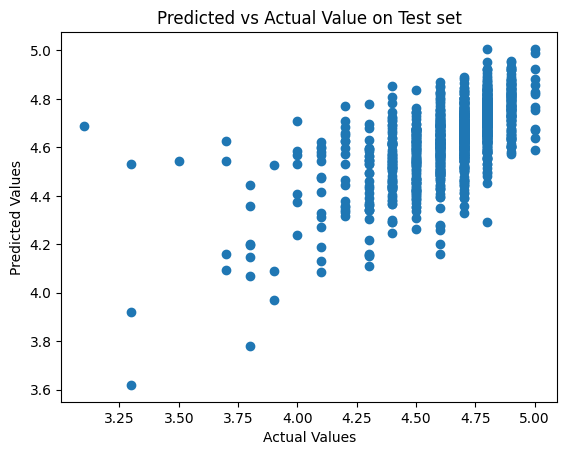

In [13]:
plt.scatter(y_test, y_test_pred)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual Value on Test set')
plt.show()

**Write model evaluation results to csv file**

In [14]:
evaluation = [run_time, mse_, r_square_]
with open('evaluation.csv', 'a', newline='') as file:
    csv_writer = csv.writer(file)
    csv_writer.writerow(evaluation)